# Krypton Lifetime

## Produce lifetime map and write a DST with lifetime-corrected energies

### Input files

In [1]:
input_path  = f"$IC_DATA/dst"
output_path = f"$IC_DATA/ldst"
map_path    = f"$IC_DATA/maps"

input_file_names  = ['dst_6206_0000_4999.h5', 'dst_6206_5001_9999.h5','dst_6206_10001_19999.h5']
output_file_name  = 'ldst_6206_0000_19999.h5'
map_file_name     = 'lmap_6206_0000_19999.h5'

### Notebook configuration

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
import datetime
import collections
import glob
import warnings
import matplotlib.pyplot as plt

import tables            as tb
import numpy             as np
import matplotlib.dates  as md

import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io.dst_io as dstio
import invisible_cities.io  .kdst_io       as kdstio

from invisible_cities.core .core_functions import in_range
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import measurement_string
import invisible_cities.reco    .corrections    as corrf

from icaro.core.fit_functions import quick_gauss_fit
from icaro.core.fit_functions import to_relative
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)


In [4]:
from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import KrMeanAndStd
from core.kr_types import KrLTLimits

from core.kr_core_functions import kr_event
from core.kr_core_functions import kr_times_ranges_and_bins
from core.kr_core_functions import divide_np_arrays
from core.kr_core_functions import file_numbers_from_file_range
from core.kr_core_functions import fiducial_volumes
from   invisible_cities.evm  .ic_containers  import Measurement

In [5]:
import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp

In [6]:
from   invisible_cities.core.core_functions import weighted_mean_and_std
from   invisible_cities.core.core_functions import loc_elem_1d
from   invisible_cities.types.ic_types import minmax

In [7]:
from icaro.core.fit_functions import expo_seed, gauss_seed

In [8]:
from typing      import NamedTuple

In [9]:
# Plotting style
default_cmap = "viridis"
figure_size  = 8, 6
font_size    = 15

plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size

warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)
from icaro.core.fit_functions import conditional_labels

labels = conditional_labels(True)

profOpt = "--k"
fitOpt  = "r"


In [10]:
from ipywidgets import interact, interactive, fixed
from IPython.display import display

In [11]:
print("This notebook has been run on ", time.asctime())

This notebook has been run on  Tue Jul 17 07:21:19 2018


### Read data

In [13]:
path  = input_path
opath = output_path
mpath = map_path

input_dst_filenames = [os.path.expandvars(f"{path}/{file_name}") for file_name in input_file_names]
output_dst_filename = os.path.expandvars(f"{opath}/{output_file_name}")
map_filename        = os.path.expandvars(f"{mpath}/{map_file_name}")


print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")

input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_0000_4999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/dst/dst_6206_10001_19999.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206_0000_19999.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6206_0000_19999.h5


In [14]:
dst           = krc.load_dsts(input_dst_filenames, "DST", "Events")

In [15]:
unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)

print(f"Total number of events: {number_of_evts_full}")

Total number of events: 2606375


In [16]:
dst.columns

Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')

### Ranges and binning

In [19]:
krTimes, krRanges, krNBins, krBins = kr_times_ranges_and_bins(dst,
                                                              Zrange  = ( 100,  550),
                                                              XYrange = (-200,  200),
                                                              Erange  = ( 2e3, 12.5e3),
                                                              S1range = (   2,   25),
                                                              Qrange  = ( 100, 800),
                                                              Znbins        =   10,
                                                              XYnbins       =   60,
                                                              Enbins        =   50,
                                                              S1nbins       =   20,
                                                              Qnbins        =   25,
                                                              nStimeprofile = 3600)

In [20]:
print(krRanges, krNBins)

KrRanges(Z=(100, 550), XY=(-200, 200), E=(2000.0, 12500.0), S1=(2, 25), Q=(100, 800), T=(1531471716.4420002, 1531607454.6619999)) KrNBins(Z=10, XY=60, E=50, S1=20, Q=25, T=37)


### Fiducial volumes

In [21]:
kdst= fiducial_volumes(dst,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)

 nfull : 2544271: eff_full = 0.976172269915112 
 nfid : 1412009: eff_fid = 0.5417520502613784 
 ncore : 619991: eff_core = 0.23787482614742697 
 nhcore : 154786: eff_hcore = 0.059387463431010507 


### Time 

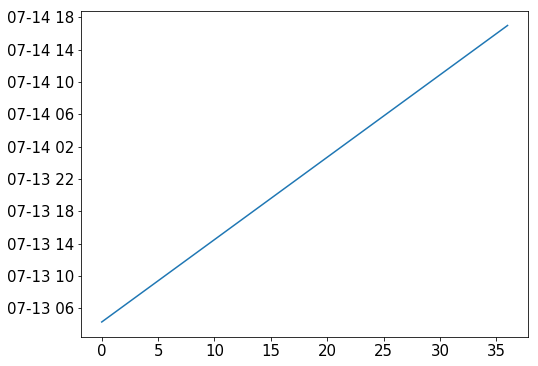

In [22]:
plt.plot(krTimes.timeStamps)

### Event distribution

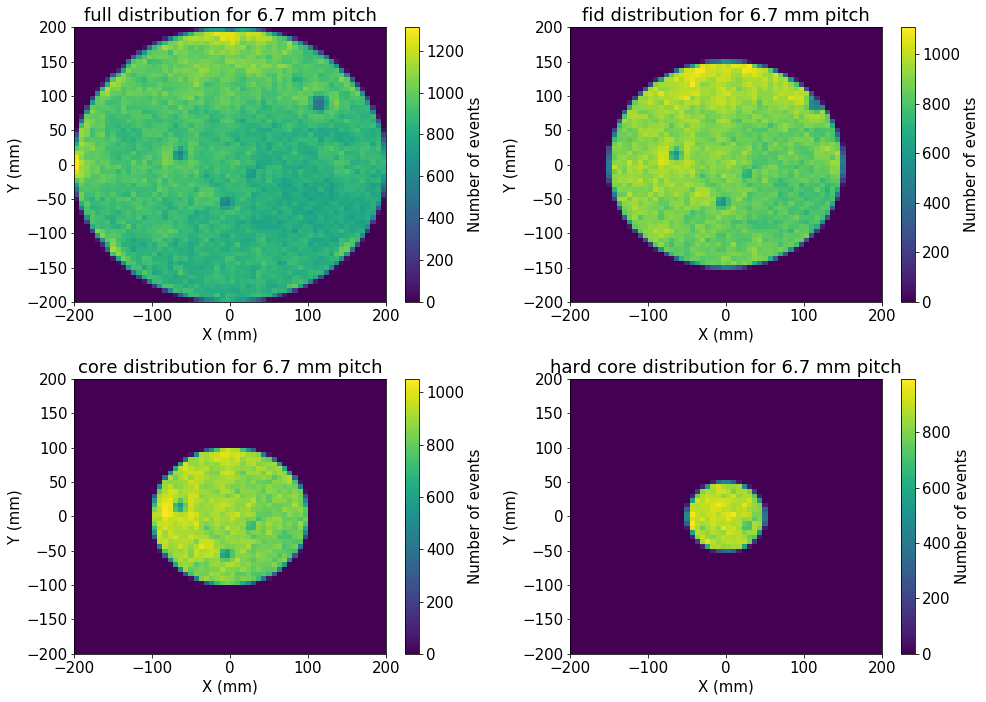

In [23]:
nEvt = krp.plot_xy_density(kdst, krBins)

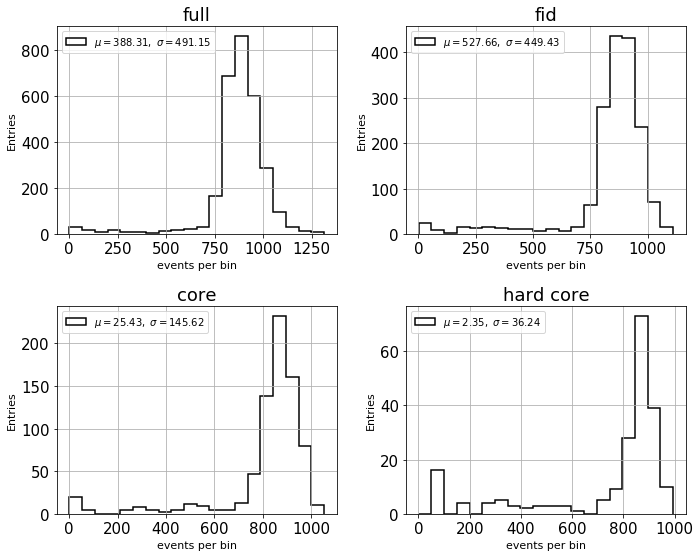

In [24]:
stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

### Evolution of S12 with time full

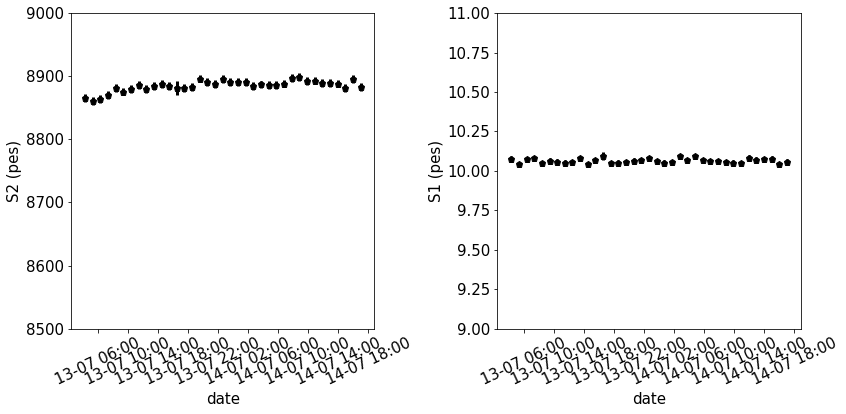

In [25]:
krf.s12_time_profile(kdst.full, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(8500, 9000), s1lim=(9,11), figsize=(12,6))

### Evolution of S12 with time hard core

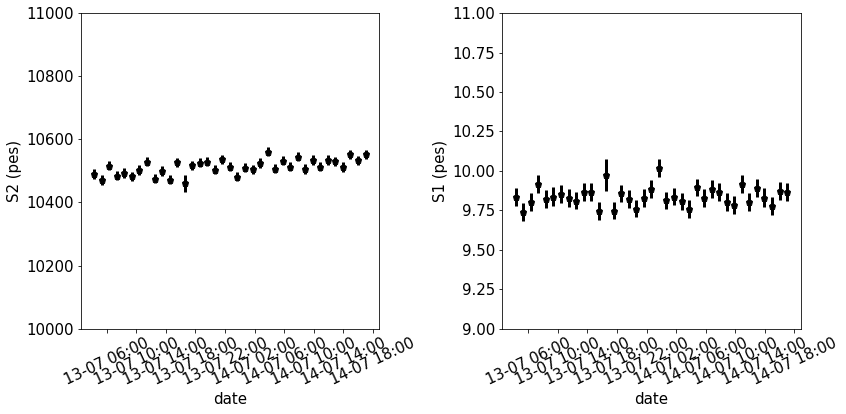

In [26]:
krf.s12_time_profile(kdst.hcore, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(10000, 11000), s1lim=(9,11), figsize=(12,6))

### S2 & S1 full

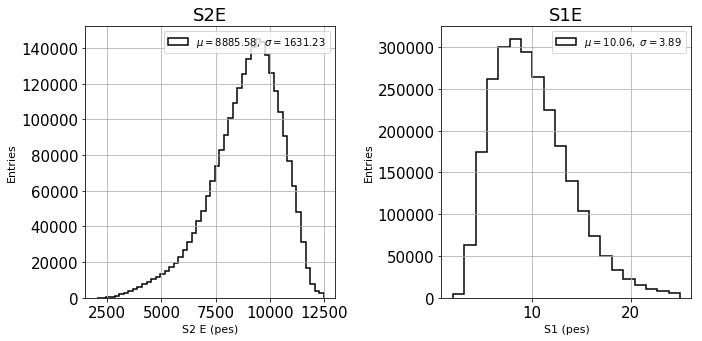

In [27]:
stats = krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.full.E, kdst.full.S1), bins=(krNBins.E, krNBins.S1), 
                names = ('S2E','S1E'),
                ranges =(krRanges.E, krRanges.S1),
                xlabels =('S2 E (pes)','S1 (pes)'),
                ylabels =('Entries','Entries'),
                titles = ('S2E','S1E'),
                legends = ('best','best'),
                figsize =(10,5))

In [28]:
stats

{'S1E': Measurement(value=10.063217956996546, uncertainty=3.8939082779868484),
 'S2E': Measurement(value=8885.5755641933411, uncertainty=1631.2292734328323)}

### S2 & S1 hard core

{'S1E': Measurement(value=9.8362820451107424, uncertainty=3.7021368694378096),
 'S2E': Measurement(value=10503.05165277931, uncertainty=951.32640623453176)}

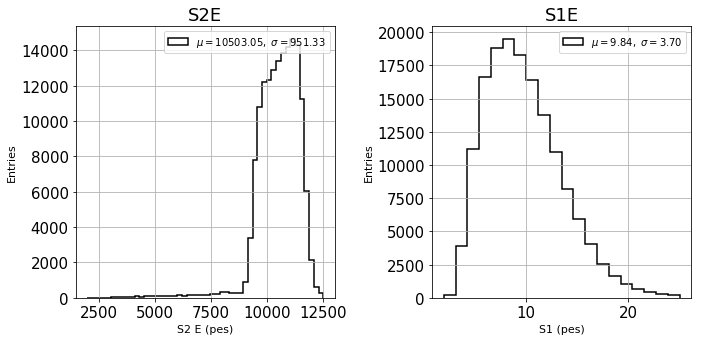

In [29]:
krh.h1n(n=2, nx=1, ny=2, h1ds=(kdst.hcore.E, kdst.hcore.S1), bins=(krNBins.E, krNBins.S1), 
        names=('S2E','S1E'),
    ranges =(krRanges.E, krRanges.S1),
    xlabels =('S2 E (pes)','S1 (pes)'),
    ylabels =('Entries','Entries'),
    titles = ('S2E','S1E'),
    legends = ('best','best'),
    figsize =(10,5))

### S2 vs Z

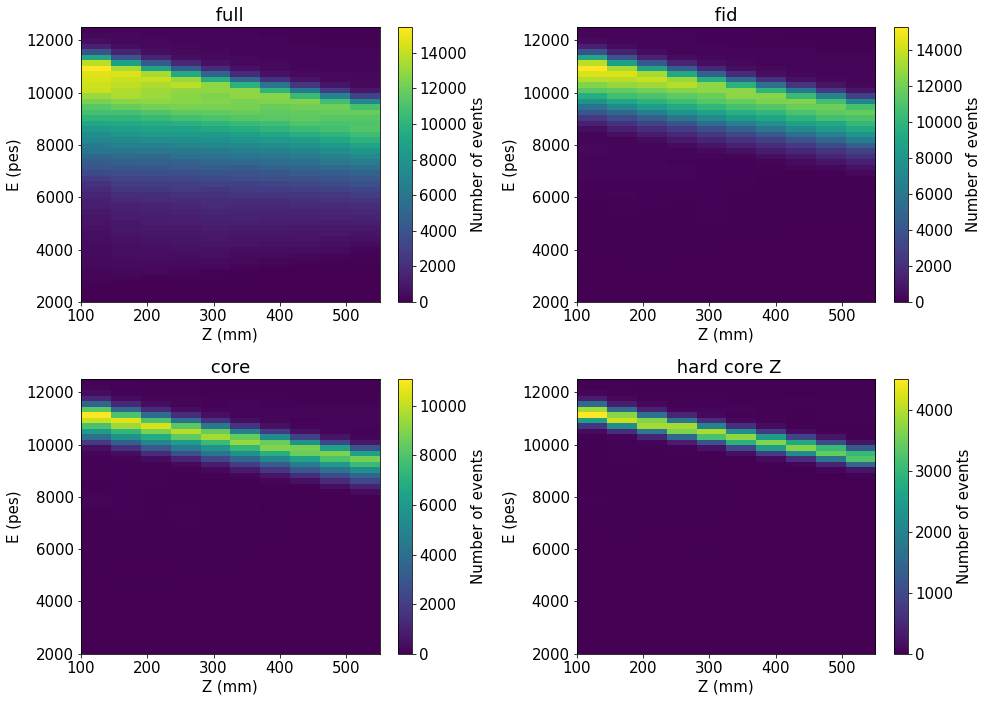

In [30]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

### Fit lifetime in hard core

 E (z=0) = 11548.056597937053 +-6.11812679749986 
 LT      = -2805.401354747809 +-11.54764223213593 
 chi2    = 2.04960198620113 


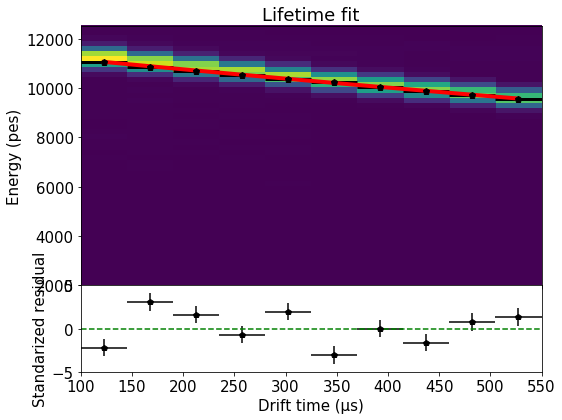

In [31]:
xlim =  -50, 50
ylim =  -50, 50
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.hcore, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit lifetime in core

 E (z=0) = 11308.378868647407 +-3.2550379772970754 
 LT      = -2707.9562518842135 +-5.946431801244924 
 chi2    = 2.333233356233846 


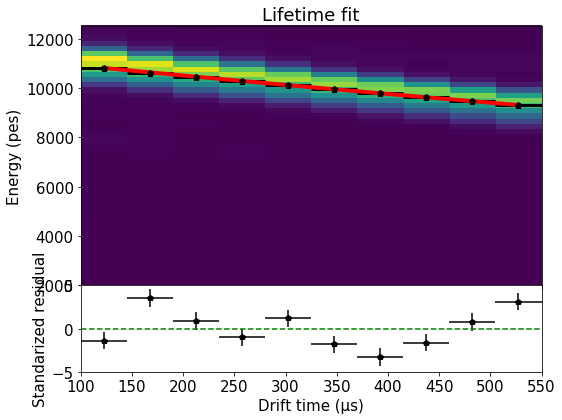

In [32]:
xlim =  -100, 100
ylim =  -100, 100
xyr = XYRanges(X=xlim, Y=ylim )
kf = krf.lifetime_in_XYRange(kdst.core, krNBins, krBins, krRanges, xyr)
krf.print_fit(kf)

### Fit in four quadrants

xlim = (-125, -75), ylim =(-125, -75)
xlim = (-125, -75), ylim =(75, 125)
xlim = (75, 125), ylim =(75, 125)
xlim = (75, 125), ylim =(-125, -75)
 E (z=0) = 11096.749962629037 +-12.347036231271595 
 LT      = -2684.1646953352856 +-21.75437883357266 
 chi2    = 1.6906699617173961 
 E (z=0) = 10201.494339318244 +-12.54292474788963 
 LT      = -2380.6145525559728 +-19.635169173566364 
 chi2    = 1.216620344441196 
 E (z=0) = 9885.642500348005 +-11.195073428562194 
 LT      = -2301.5409304077552 +-17.39571446316345 
 chi2    = 1.080158477878768 
 E (z=0) = 10312.349350820128 +-10.819277148189808 
 LT      = -2542.418259918385 +-19.689737176041852 
 chi2    = 0.9654626980133166 


[None, None, None, None]

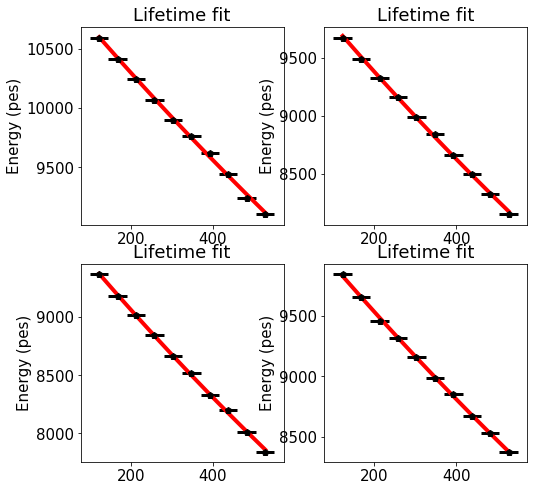

In [33]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-125, -75), (-125, -75), (75, 125),(75, 125)],
                         YL = [(-125, -75), (75, 125), (75, 125),(-125, -75)],
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

### Fit low and hig regions

xlim = (-100, 100), ylim =(125, 200)
xlim = (0, 200), ylim =(-50, 50)
 E (z=0) = 9609.125836928142 +-8.93737378354703 
 LT      = -2178.6026200583788 +-13.098229710815273 
 chi2    = 1.8774275162413137 
 E (z=0) = 10893.368423626094 +-4.974363377576794 
 LT      = -2798.991271159402 +-10.3578892032665 
 chi2    = 2.193295560608197 


[None, None]

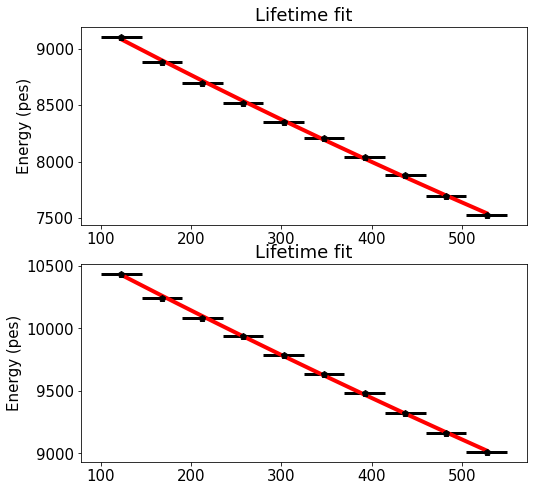

In [34]:
KF = krf.lifetimes_in_XYRange(kdst.fid, krNBins, krBins, krRanges, xyr,
                         XL = [(-100, 100), (0, 200)],
                         YL = [(125, 200), (-50, 50)],
                         nx = 2, ny = 1, 
                         figsize=(8,8))
[krf.print_fit(kf) for kf in KF ]

In [35]:
es_low = KF[0].par[0]
esu_low = KF[0].err[0]
es_hig = KF[1].par[0]
esu_hig = KF[1].err[0]
lt_low = np.abs(KF[0].par[1])
ltu_low = np.abs(KF[0].err[1])
lt_hig = np.abs(KF[1].par[1])
ltu_hig = np.abs(KF[1].err[1])
print(f"LOW:  es +- err = {es_low} +- {esu_low}")
print(f"High:  es +- err = {es_hig} +- {esu_hig}")
print(f"LOW:  lt +- err = {lt_low} +- {ltu_low}")
print(f"High:  lt +- err = {lt_hig} +- {ltu_hig}")

LOW:  es +- err = 9609.125836928142 +- 8.93737378354703
High:  es +- err = 10893.368423626094 +- 4.974363377576794
LOW:  lt +- err = 2178.6026200583788 +- 13.098229710815273
High:  lt +- err = 2798.991271159402 +- 10.3578892032665


### Time profile of LT in the fiducial

In [36]:
fits = krf.lifetimes_in_TRange(kdst.fid, krNBins, krBins, krRanges,  TL=krTimes.TL)

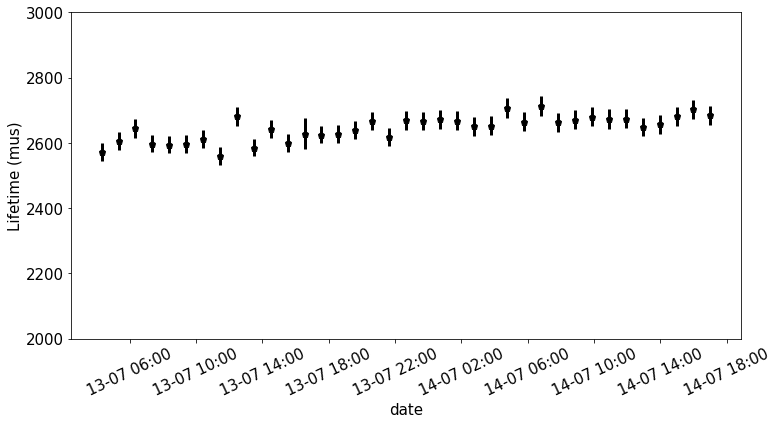

In [37]:
krp.plot_lifetime_T(fits, krTimes.timeStamps, ltlim=(2000, 3000),  figsize=(12,6))

### Time profile of LT in hard core

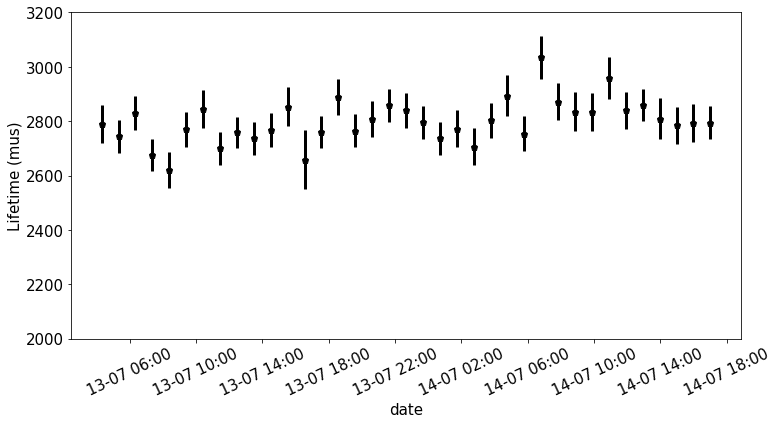

In [38]:
fits = krf.lifetimes_in_TRange(kdst.hcore, krNBins, krBins, krRanges,  TL=krTimes.TL)
krp.plot_lifetime_T(fits, krTimes.timeStamps,ltlim=(2000, 3200),  figsize=(12,6))

### Compute lifetime maps

In [85]:
krfs = krf.fit_lifetime_slices(kdst.full, krNBins, krBins, krRanges, fit_var = "E", min_entries=100)

/Users/jjgomezcadenas/Projects/IC/invisible_cities/core/fit_functions.py:135: RuntimeWarning: invalid value encountered in less_equal
  if np.any(sigma_r <= 0):
/Users/jjgomezcadenas/miniconda/envs/IC3.6/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [86]:
Escale_abs, ELT_abs, Echi2, valid = krfs.Es, krfs.LT, krfs.chi2, krfs.valid  
Escale     = to_relative(Escale_abs, percentual=True)  # errors in %
ELT        = to_relative(ELT_abs, percentual=True)

In [87]:
valid.shape

(60, 60)

In [88]:
El = KrMeanAndStd(mu    = np.nanmean(ELT      .value      [valid]),
                  std   = np.nanstd (ELT      .value      [valid]),
                  mu_u  = np.nanmean(ELT      .uncertainty[valid]),
                  std_u = np.nanstd (ELT      .uncertainty[valid]))
Es = KrMeanAndStd(mu    = np.nanmean(Escale   .value      [valid]),
                  std   = np.nanstd (Escale   .value      [valid]),
                  mu_u  = np.nanmean(Escale   .uncertainty[valid]),
                  std_u = np.nanstd (Escale   .uncertainty[valid]))

print(f'Lifetime value           : mu +- std ={El.mu} +- {El.std}')
print(f'Lifetime uncertainty     : mu +- std ={El.mu_u} +- {El.std_u}')
print(f'Energy scale value       : mu +- std ={Es.mu} +- {Es.std}')
print(f'Energy scale uncertainty : mu +- std ={Es.mu_u} +- {Es.std_u}')

Lifetime value           : mu +- std =-1129.9155321426183 +- 278.9579866772044
Lifetime uncertainty     : mu +- std =20.360355318414207 +- 15.867346654698586
Energy scale value       : mu +- std =4548.61189645719 +- 28.30551437793565
Energy scale uncertainty : mu +- std =4.116601519260618 +- 1.6646610089560283


In [44]:
n_sigma  = 2.5
u_sigma  = 2.5
kltl = KrLTLimits(Es  = minmax(Es.mu - n_sigma * Es.std, Es.mu + n_sigma * Es.std),
                  LT  = minmax(El.mu - n_sigma * El.std,El.mu + n_sigma * El.std),
                  Eu  = minmax(max(Es.mu_u - u_sigma * Es.std_u, 1e-3),  
                              Es.mu_u + u_sigma * Es.std_u),
                  LTu = minmax(max(El.Python 3
Krypton XY map
Produce a geometry map
In [42]:

input_path  = f"$IC_DATA/ldst"
output_path = f"$IC_DATA/gdst"
map_path    = f"$IC_DATA/maps"
​
input_file_names  = ['ldst_6206_0000_19999.h5']
output_file_name  = 'gdst_6206_0000_19999.h5'
map_file_name     = 'gmap_6206_0000_19999.h5'
In [43]:

%matplotlib inline
%load_ext autoreload
%autoreload 2
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Notebook configuration
In [44]:

import os
import time
import datetime
import collections
import warnings
import pandas as pd
import tables            as tb
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib.dates  as md
​
import invisible_cities.core.fit_functions as fitf
import invisible_cities.reco.dst_functions as dstf
import invisible_cities.io  .kdst_io       as kdstio
​
from invisible_cities.core .core_functions import in_range
from invisible_cities.core .stat_functions import poisson_sigma
from invisible_cities.icaro. hst_functions import hist
from invisible_cities.icaro. hst_functions import display_matrix
from invisible_cities.icaro. hst_functions import shift_to_bin_centers
from invisible_cities.icaro. hst_functions import plot_writer
​
from icaro.core.fit_functions import gauss_seed
from icaro.core.fit_functions import relative_errors
from icaro.core.fit_functions import conditional_labels
​
In [45]:

import core.kr_histo_functions as krh
import core.kr_core_functions as krc
import core.kr_fit_functions as krf
import core.kr_plt_functions as krp
In [86]:

from core.kr_types import KrEvent, DstEvent, KrRanges, KrNBins, KrBins, KrFit, XYRanges, Ranges
from core.kr_types import XyzRanges, XyzNBins, XyzBins
from core.kr_types import KrMeanAndStd, KrMeanStdMinMax
from core.kr_types import KrLTLimits
from core.kr_types import ExyAvg
from   invisible_cities.evm  .ic_containers  import Measurement
In [47]:

from core.kr_core_functions import kr_event
from core.kr_core_functions import kr_times_ranges_and_bins
from core.kr_core_functions import kr_ranges_and_bins
from core.kr_core_functions import fiducial_volumes
In [48]:

# Plotting style
default_cmap = "viridis"
figure_size  = 8, 6
font_size    = 15
​
plt.rcParams["figure.figsize"] = figure_size
plt.rcParams[  "font.size"   ] =   font_size
​
warnings.filterwarnings('ignore', category=tb.NaturalNameWarning)
from icaro.core.fit_functions import conditional_labels
​
labels = conditional_labels(True)
​
​
Read data
In [49]:

path  = input_path
opath = output_path
mpath = map_path
​
input_dst_filenames = [os.path.expandvars(f"{path}/{file_name}") for file_name in input_file_names]
output_dst_filename = os.path.expandvars(f"{opath}/{output_file_name}")
map_filename        = os.path.expandvars(f"{mpath}/{map_file_name}")
​
​
print(f'input dsts:\n first = {input_dst_filenames[0]}\n last = {input_dst_filenames[-1]}')
print(f"output dst = {output_dst_filename}")
print(f"map file   = {map_filename}")
input dsts:
 first = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206_0000_19999.h5
 last = /Users/jjgomezcadenas/Projects/ICDATA/ldst/ldst_6206_0000_19999.h5
output dst = /Users/jjgomezcadenas/Projects/ICDATA/gdst/gdst_6206_0000_19999.h5
map file   = /Users/jjgomezcadenas/Projects/ICDATA/maps/gmap_6206_0000_19999.h5
In [67]:

dst = krc.load_dsts(input_dst_filenames, "DST", "Events")
In [68]:

unique_events = ~dst.event.duplicated()
number_of_evts_full = np.count_nonzero(unique_events)
​
print(f"Total number of events: {number_of_evts_full}")
Total number of events: 2606375
In [69]:

dst.columns
Out[69]:
Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')
Ranges and binning
In [70]:

eRanges, eNBins, eBins = kr_ranges_and_bins(Zrange  = ( 100,  550),
                                                     XYrange = (-200,  200),
                                                     Erange  = ( 2e3, 12.5e3),
                                                     S1range = (   2,   25),
                                                     Qrange  = ( 100, 1000),
                                                     Znbins        =   10,
                                                     XYnbins       =   100,
                                                     Enbins        =   50,
                                                     S1nbins       =   10,
                                                     Qnbins        =   25)
pitch = eBins.pXY
Fiducial volumes
In [71]:

kdst= fiducial_volumes(dst,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)
 nfull : 2544271: eff_full = 0.976172269915112 
 nfid : 1412009: eff_fid = 0.5417520502613784 
 ncore : 619991: eff_core = 0.23787482614742697 
 nhcore : 154786: eff_hcore = 0.059387463431010507 
Event distribution
In [72]:

nEvt = krp.plot_xy_density(kdst, eBins)

Event distribution
In [73]:

stats = krh.h1n(n=4, nx=2, ny=2, 
                names = ("nevt_full", "fnevt_id", "nevt_core", "nevt_hard core"),
                h1ds = (nEvt.full.flatten(), nEvt.fid.flatten(), nEvt.core.flatten(), nEvt.hcore.flatten()),
                bins = (20, 20, 20, 20),
                ranges = ((1, int(np.max(nEvt.full)) + 2), (1, int(np.max(nEvt.fid)) + 2), 
               (1, int(np.max(nEvt.core)) + 2), (1, int(np.max(nEvt.hcore)) + 2)),
               xlabels = ("events per bin", "events per bin", "events per bin", "events per bin"),
               ylabels = ("Entries", "Entries", "Entries", "Entries"),
               titles = ("full", "fid", "core", "hard core"),
               legends = ("upper left", "upper left", "upper left", "upper left"),
               figsize =(10,8))

In [74]:

krp.plot_s2_vs_z(kdst, eBins, figsize=(14,10))

Compute geometry map
In [83]:

def xy_emap(kdst, enbins, eranges):
    *_, eave, eaveu = fitf.profileXY(kdst.X, kdst.Y, kdst.E, 
                                       enbins.XY, enbins.XY, eranges.XY, eranges.XY)
    eaveu_             = relative_errors(eave, eaveu, percentual=True)
    eok                = eave > 1e3
    eXYavg             = ExyAvg(E = eave, Eu = eaveu)
    return eXYavg, eok
In [84]:

eXYavg, eok = xy_emap(kdst.full, eNBins, eRanges)
In [85]:

eXYavg.E.shape
Out[85]:
(100, 100)
In [106]:

eok.shape
Out[106]:
(100, 100)
In [102]:

eBins.XY
Out[102]:
array([-200., -196., -192., -188., -184., -180., -176., -172., -168.,
       -164., -160., -156., -152., -148., -144., -140., -136., -132.,
       -128., -124., -120., -116., -112., -108., -104., -100.,  -96.,
        -92.,  -88.,  -84.,  -80.,  -76.,  -72.,  -68.,  -64.,  -60.,
        -56.,  -52.,  -48.,  -44.,  -40.,  -36.,  -32.,  -28.,  -24.,
        -20.,  -16.,  -12.,   -8.,   -4.,    0.,    4.,    8.,   12.,
         16.,   20.,   24.,   28.,   32.,   36.,   40.,   44.,   48.,
         52.,   56.,   60.,   64.,   68.,   72.,   76.,   80.,   84.,
         88.,   92.,   96.,  100.,  104.,  108.,  112.,  116.,  120.,
        124.,  128.,  132.,  136.,  140.,  144.,  148.,  152.,  156.,
        160.,  164.,  168.,  172.,  176.,  180.,  184.,  188.,  192.,
        196.,  200.])
In [101]:

eBins.XY[0]
Out[101]:
-200.0
In [107]:

np.count_nonzero(eok) / (eok.shape[0] * eok.shape[1])
Out[107]:
0.8012
In [109]:

eXYavg.E[20][20]
Out[109]:
10365.126554330933
In [110]:

eXYavg.Eu[20][20]
Out[110]:
42.658796077647146
In [90]:

def xy_emap_avg(eXYavg, eok):
    E_mean  = np.mean(eXYavg.E [eok])
    E_std   = np.std (eXYavg.E [eok])
    Eu_mean = np.mean(eXYavg.Eu [eok])
    Eu_std  = np.std (eXYavg.Eu [eok])
    
    E_min   =      E_mean - 2.5 *  E_std
    E_max   =      E_mean + 2.5 *  E_std
​
    Eu_min  = max(Eu_mean - 2.5 * Eu_std, 1e-3)
    Eu_max  =     Eu_mean + 2.5 * Eu_std
    
    eMapAvg = KrMeanStdMinMax(mu    = E_mean,
                              std   = E_std,
                              mu_u  = Eu_mean,
                              std_u = Eu_std,
                              min   = E_min,
                              max   = E_max,
                              min_u = Eu_min,
                              max_u = Eu_max)
    return eMapAvg
In [92]:

eMapAvg = xy_emap_avg(eXYavg, eok)
In [93]:

eMapAvg
Out[93]:
KrMeanStdMinMax(mu=9900.2343828557514, std=1436.8250929227988, mu_u=48.06243554360227, std_u=33.436733676008949, min=6308.1716505487548, max=13492.297115162748, min_u=0.001, max_u=131.65426973362463)
Fit example
In [96]:

ti = time.time()
kf = krf.energy_in_XYRange(kdst.full, 
                           xr = (-5,  5),
                           yr = (-5,  5),
                           ernb = eNBins)
to = time.time()
print(to - ti)
kf
0.10489296913146973
Out[96]:
KrFit(par=array([  4.54141808e+05,   1.17429713e+04,   2.45586809e+02]), err=array([  1.02902368e+04,   5.56498134e+00,   4.12173490e+00]), chi2=1.6920100661162212)

In [95]:

kf = krf.energy_in_XYRange(kdst.full, 
                           xr = (100,  105),
                           yr = (100,  105),
                           ernb = eNBins)
kf
Out[95]:
KrFit(par=array([ 86168.85136772,   9666.692926  ,    192.47469674]), err=array([ 3763.02600576,     8.40713506,     6.75782006]), chi2=1.3970319688869475)

Energy map display
In [71]:

fig = plt.figure(figsize=(10,16))
pitch = eBins.pXY
fig.add_subplot(2, 1, 1)
*_, cb = display_matrix(eBins.cXY, eBins.cXY, Eave,
                        vmin = E_min,
                        vmax = E_max,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("Average energy (pes)")
labels("X (mm)", "Y (mm)", f"Average energy for {pitch:.1f} mm pitch")
fig.add_subplot(2, 1, 2)
*_, cb = display_matrix(eBins.cXY, eBins.cXY, Eaveu,
                            vmin = Eu_min,
                            vmax = Eu_max,
                            cmap = default_cmap,
                            new_figure = False)
cb.set_label("Average energy uncertainty(%)")
labels("X (mm)", "Y (mm)", f"Average energy unc. for {pitch:.1f} mm pitch")
​
plt.tight_layout()
​
​
​
​

Produce HDF5 output
In [75]:

with tb.open_file(geo_filename, "w") as output_file:
   
    pitch      = eBins.pXY
    group      =  "XYcorrections"
    table_name = f"GeometryE_{pitch:.1f}mm"
        
    write = kdstio.xy_correction_writer(output_file,
                                            group      = group,
                                            table_name = table_name)
    write(eBins.cXY, eBins.cXY, Eave, Eaveu * Eave / 100, nEvt.full)
​
    table = getattr(getattr(output_file.root, group), table_name)
    table.attrs.xy_bins  = eBins.XY
    table.attrs.xy_pitch = pitch
​
​
Write DST (merged and fiducial)
In [76]:

dst.columns
Out[76]:
Index(['index', 'event', 'time', 's1_peak', 's2_peak', 'nS1', 'nS2', 'S1w',
       'S1h', 'S1e', 'S1t', 'S2w', 'S2h', 'S2e', 'S2q', 'S2t', 'Nsipm', 'DT',
       'Z', 'Zrms', 'X', 'Y', 'R', 'Phi', 'Xrms', 'Yrms'],
      dtype='object')
In [77]:

del dst['index']
In [79]:

dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)
​
​
In [80]:

with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"
In [ ]:

​
Kr_geometry.ipynb

mu_u - u_sigma * El.std_u, 1e-3),
                              El.mu_u + u_sigma * El.std_u))
 


print(f" Energy scale (E): E_min = {kltl.Es.min}; E_max = {kltl.Es.max}")
print(f" Lifetime (ELT): ELT_min = {kltl.LT.min}; ELT_max = {kltl.LT.max}")
print(f" Energy scale error (Eu): Eu_min = {kltl.Eu.min}; Eu_max = {kltl.Eu.max}")
print(f" Lifetime error (ELTu): ELTu_min = {kltl.LTu.min}; ELTu_max = {kltl.LTu.max}")

 Energy scale (E): E_min = 6661.417971997507; E_max = 13337.12699155356
 Lifetime (ELT): ELT_min = 1211.7604129615581; ELT_max = 3520.0867850804298
 Energy scale error (Eu): Eu_min = 0.001; Eu_max = 1.7810639124373382
 Lifetime error (ELTu): ELTu_min = 0.001; ELTu_max = 9.84824151580927


### Map display

In [45]:
invalid = ~valid
mask = valid

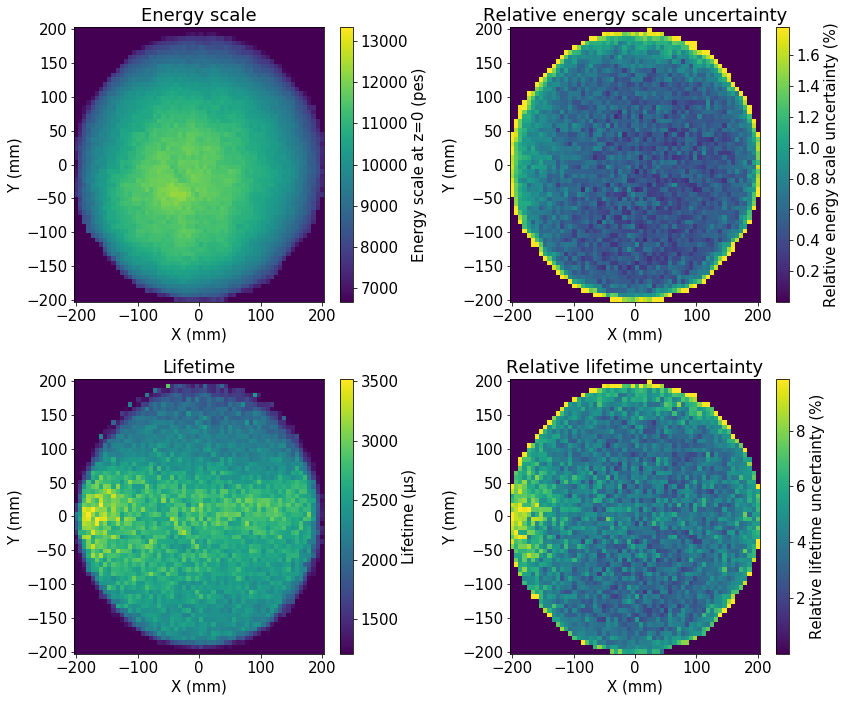

In [53]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="viridis", mask=valid)
                         

(1.2348666541655258, 0.62730693032592555)

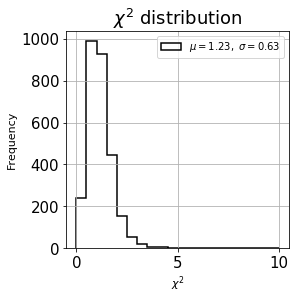

In [47]:
krp.figsize("S")
krh.h1d(Echi2[valid], bins=20, range=(0,10), xlabel="$\chi^2$", ylabel='Frequency',
        title="$\chi^2$ distribution", legend = 'upper right', figsize=(4,4))

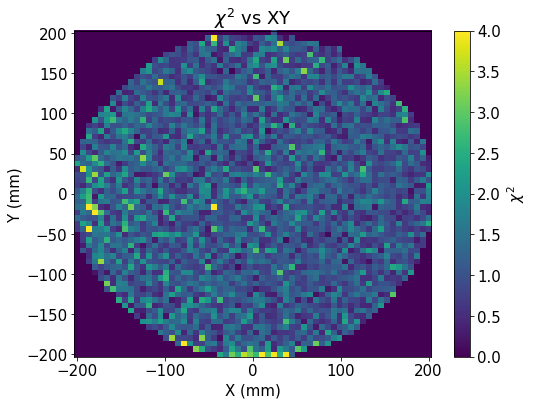

In [48]:
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(1, 1, 1)
#plt.subplot(1, 1, 1)
*_, cb = display_matrix(krBins.cXY, krBins.cXY, Echi2, mask=valid,
                        vmin = 0, vmax = 4,
                        cmap = default_cmap,
                        new_figure = False)
cb.set_label("$\chi^2$")
labels("X (mm)", "Y (mm)", "$\chi^2$ vs XY")

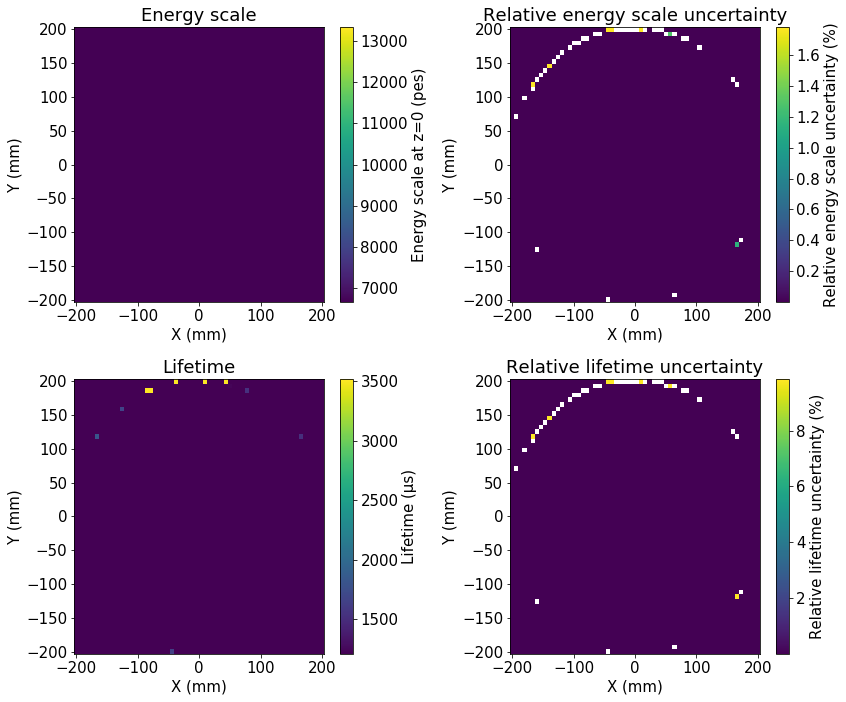

In [54]:
krp.figsize("L")
krp.display_lifetime_maps(Escale, ELT, kltl, krBins.cXY, cmap="viridis", mask=invalid)

### Fix map

- Fit fails in the corona
- Fill bins where fit has failed with average low level of lifetime


In [50]:
Escale_abs_corr = Measurement(np.where(valid,  Escale_abs.value ,     es_low), 
                     np.where(valid, Escale_abs.uncertainty,       esu_low ))

ELT_abs_corr = Measurement(np.where(valid,   ELT_abs.value        , lt_low), 
                  np.where(valid,  ELT_abs.uncertainty,    ltu_low))

In [51]:
Escale_corr     = to_relative(Escale_abs_corr, percentual=True)  # errors in %
ELT_corr        = to_relative(ELT_abs_corr, percentual=True)

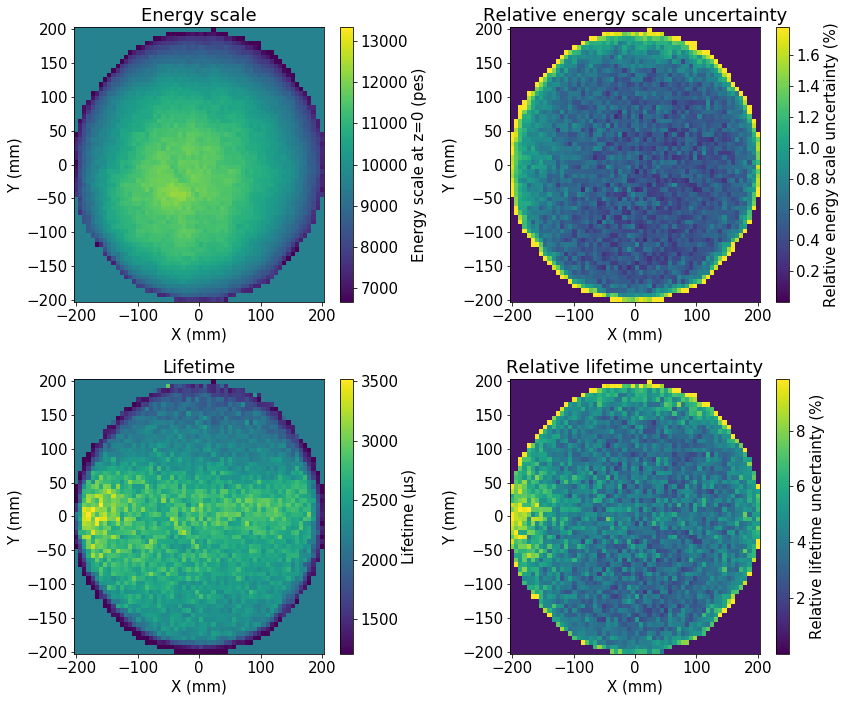

In [55]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="viridis", mask=None)

In [126]:
gvalid   = np.zeros((krNBins.XY,krNBins.XY), dtype=bool)

In [127]:
def gfid(gvalid):
    for i in range(krNBins.XY):
        for j in range(krNBins.XY):
            if  np.sqrt(krBins.cXY[i]**2 + krBins.cXY[j]**2) < krRanges.XY[1] :
                    gvalid[i, j] = True

In [128]:
gfid(gvalid)

In [129]:
np.count_nonzero(gvalid) / (gvalid.shape[0] * gvalid.shape[1])

0.7855555555555556

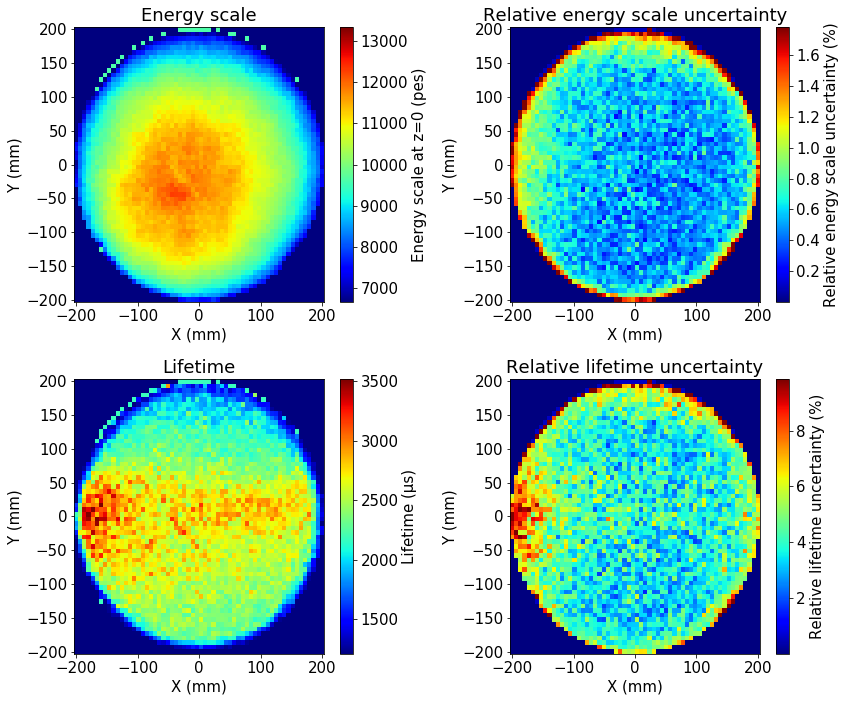

In [130]:
krp.display_lifetime_maps(Escale_corr, ELT_corr, kltl, krBins.cXY, 
                          cmap="jet", mask=gvalid)

### Produce HDF5 output

In [56]:
nevt = nEvt.fid

In [132]:
print(map_filename)

/Users/jjgomezcadenas/Projects/ICDATA/maps/lmap_6206_0000_19999.h5


In [133]:
with tb.open_file(map_filename, "w") as correction_file:
    write_escale = kdstio.xy_writer(correction_file,
                                    group       = "XYcorrections",
                                    name        = "Escale",
                                    description = "XY-dependent energy scale",
                                    compression = "ZLIB4")
    write_escale(krBins.cXY, krBins.cXY, Escale_corr.value, Escale_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Escale.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Escale.attrs.xy_pitch = krBins.pXY

    write_lifetime = kdstio.xy_writer(correction_file,
                                      group       = "XYcorrections",
                                      name        = "Lifetime",
                                      description = "XY-dependent lifetime values",
                                      compression = "ZLIB4")
    write_lifetime(krBins.cXY, krBins.cXY, ELT_corr.value, ELT_corr.uncertainty, nevt)
    correction_file.root.XYcorrections.Lifetime.attrs.xy_bins  = krNBins.XY
    correction_file.root.XYcorrections.Lifetime.attrs.xy_pitch = krBins.pXY



### Load Z correction function

In [57]:
ZcorrectionE = dstf.load_lifetime_xy_corrections(map_filename,
                                                 group = "XYcorrections",
                                                 node  = "Lifetime")

### Correct DST by lifetime

In [58]:
E = np.copy(dst.S2e.values)

In [59]:

dst.S2e = dst.S2e.values * ZcorrectionE(dst.Z, dst.X, dst.Y).value

In [60]:
Ec = dst.S2e.values

{'Ecorr ': Measurement(value=9842.1973173970982, uncertainty=1706.284645699955),
 'Eraw ': Measurement(value=8796.9281271935088, uncertainty=1719.5876733920175)}

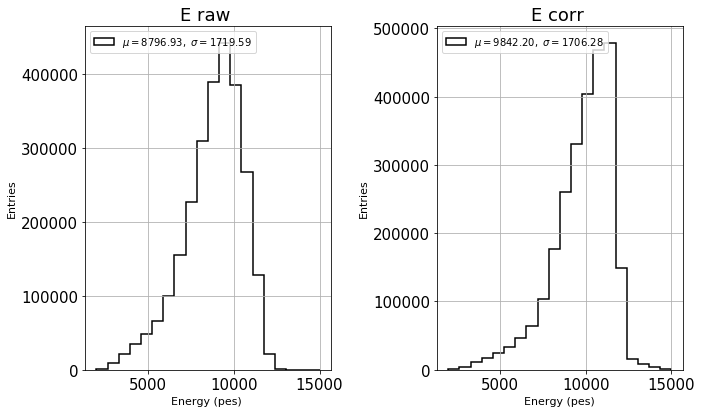

In [61]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (E, Ec),
    bins = (20, 20),
    names = ("Eraw ", "Ecorr "),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E raw ", "E corr "),
    legends = ("upper left", "upper left"),
    figsize =(10,6))

### Time profile

In [62]:
kdstc= kr_event(dst)

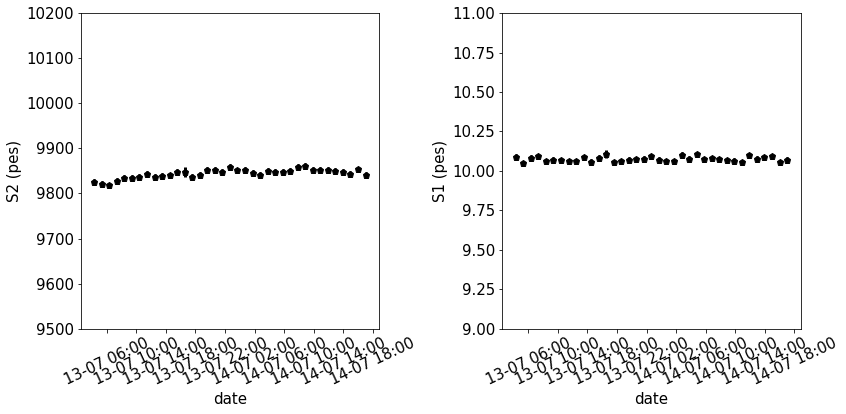

In [64]:
krf.s12_time_profile(kdstc, krNBins.T, krRanges.T, krTimes.timeStamps, s2lim=(9500, 10200), s1lim=(9,11), figsize=(12,6))

### Time correction

In [65]:
e_mu    = np.nanmean(kdstc.E)
print(e_mu)
e_std   = np.nanstd (kdstc.E)
print(e_std)

9844.1327757
1709.05661356


In [66]:
T   =(kdstc.T - kdstc.T.min()) 
t, e, eu = fitf.profileX(T, kdstc.E, 100)
ET_correction = corrf.Correction((t,), e, eu,
                                 norm_strategy =  "const",
                                 norm_opts     = {"value": e_mu})
Ekr = kdstc.E * ET_correction(T).value
tc, ec, euc = fitf.profileX(T, Ekr, 100)

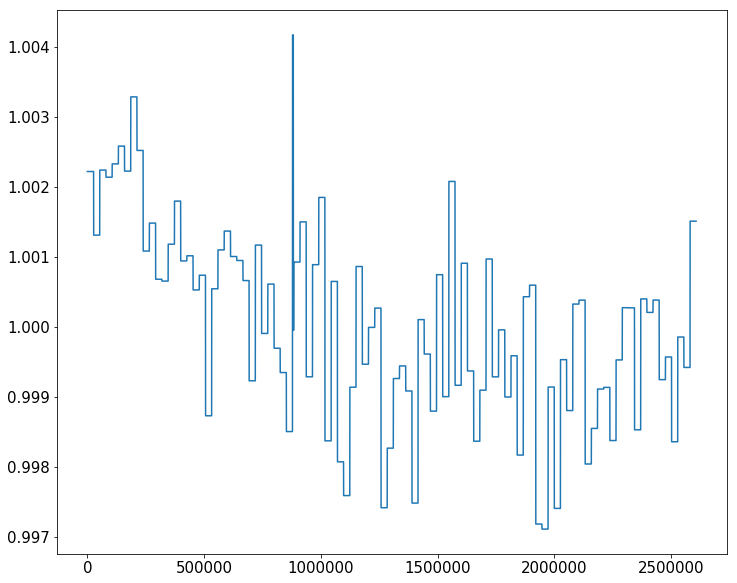

In [67]:
plt.plot(ET_correction(T).value)

In [68]:
ekr_mu    = np.nanmean(Ekr)
ekr_std   = np.nanstd (Ekr)
print(ekr_mu)
print(ekr_std)

9844.13360609
1709.01690857


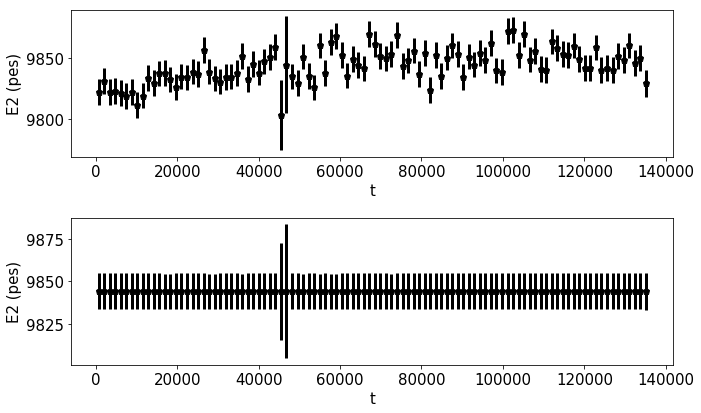

In [69]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)

plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)

plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')
plt.tight_layout()

### Notice scale. Time fluctuation below 1 %

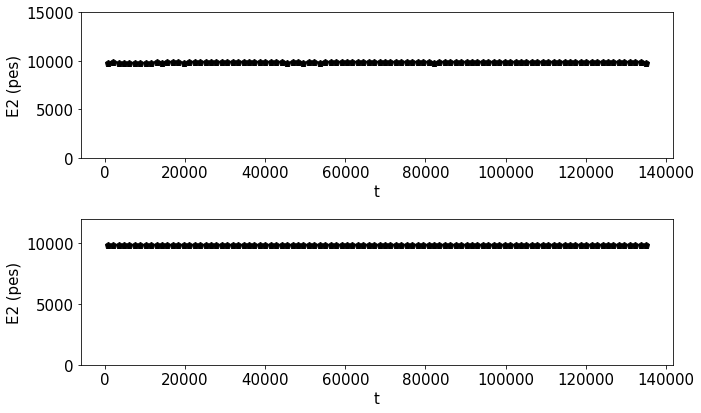

In [70]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(2, 1, 1)
plt.ylim(0, 15000)
plt.errorbar(t, e, eu, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

ax = fig.add_subplot(2, 1, 2)
plt.ylim(0, 12000)
plt.errorbar(tc, ec, euc, fmt="kp", ms=7, lw=3)
plt.xlabel('t')
plt.ylabel('E2 (pes)')

plt.tight_layout()



{'E_lt_T_corr ': Measurement(value=9844.1430907064732, uncertainty=1709.9428939724007),
 'E_lt_corr': Measurement(value=9842.1973173970982, uncertainty=1706.284645699955)}

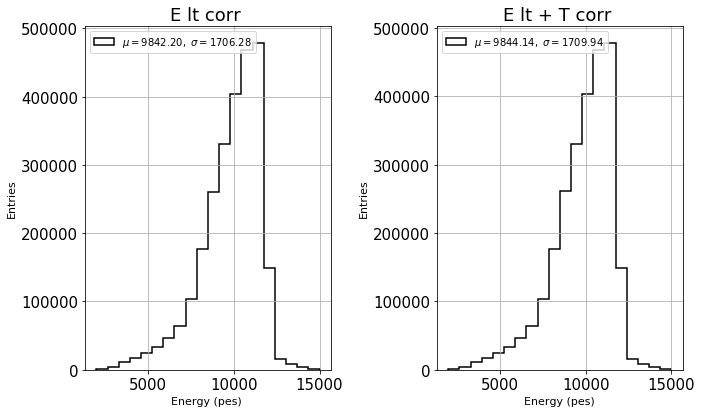

In [71]:
krh.h1n(n=2, nx=1, ny=2, 
    h1ds = (Ec, Ekr),
    bins = (20, 20),
    ranges = (( 2e3, 15e3), ( 2e3, 15e3)),
    xlabels = ("Energy (pes) ", "Energy (pes)"),
    ylabels = ("Entries", "Entries"),
    titles = ("E lt corr ", "E lt + T corr "),
    names = ("E_lt_corr", "E_lt_T_corr "),   
    legends = ("upper left", "upper left"),
    figsize =(10,6))

In [80]:
dst.S2e = Ekr

In [81]:
kdst= fiducial_volumes(dst,
                       R_full   = 200,
                       R_fid    = 150,
                       R_core   = 100,
                       R_hcore  =  50)

 nfull : 2544271: eff_full = 0.976172269915112 
 nfid : 1412009: eff_fid = 0.5417520502613784 
 ncore : 619991: eff_core = 0.23787482614742697 
 nhcore : 154786: eff_hcore = 0.059387463431010507 


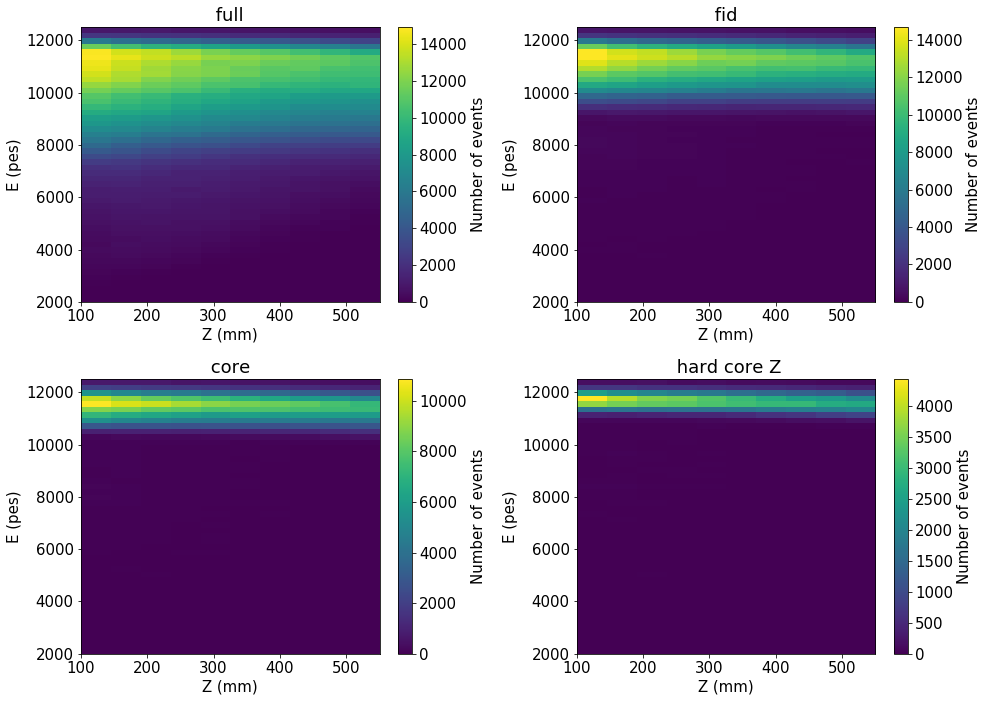

In [82]:
krp.plot_s2_vs_z(kdst, krBins, figsize=(14,10))

In [74]:
#del dst["index"]

### Write LT DST

In [84]:

dst.to_hdf(output_dst_filename,
              key     = "DST"  , mode         = "w",
              format  = "table", data_columns = True,
              complib = "zlib" , complevel    = 4)

with tb.open_file(output_dst_filename, "r+") as f:
    f.rename_node(f.root.DST.table, "Events")
    f.root.DST.Events.title = "Events"

